# Defining Expressiveness for Graph Classification

In [1]:
import torch
!pip install -q torch-scatter~=2.1.0 torch-sparse~=0.6.16 torch-cluster~=1.6.0 torch-spline-conv~=1.2.1 torch-geometric==2.2.0 -f https://data.pyg.org/whl/torch-{torch.__version__}.html

torch.manual_seed(11)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='.', name='PROTEINS').shuffle()

# Print information about the dataset
print(f'Dataset: {dataset}')
print('-----------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {dataset[0].x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Extracting ./PROTEINS/PROTEINS.zip
Processing...


Dataset: PROTEINS(1113)
-----------------------
Number of graphs: 1113
Number of nodes: 14
Number of features: 3
Number of classes: 2


Done!


In [3]:
from torch_geometric.loader import DataLoader

# Create training, validation, and test sets
train_dataset = dataset[:int(len(dataset)*0.8)]
val_dataset   = dataset[int(len(dataset)*0.8):int(len(dataset)*0.9)]
test_dataset  = dataset[int(len(dataset)*0.9):]

print(f'Training set   = {len(train_dataset)} graphs')
print(f'Validation set = {len(val_dataset)} graphs')
print(f'Test set       = {len(test_dataset)} graphs')

# Create mini-batches
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=True)

print('\nTrain loader:')
for i, batch in enumerate(train_loader):
    print(f' - Batch {i}: {batch}')

print('\nValidation loader:')
for i, batch in enumerate(val_loader):
    print(f' - Batch {i}: {batch}')

print('\nTest loader:')
for i, batch in enumerate(test_loader):
    print(f' - Batch {i}: {batch}')

Training set   = 890 graphs
Validation set = 111 graphs
Test set       = 112 graphs

Train loader:
 - Batch 0: DataBatch(edge_index=[2, 9274], x=[2468, 3], y=[64], batch=[2468], ptr=[65])
 - Batch 1: DataBatch(edge_index=[2, 8972], x=[2366, 3], y=[64], batch=[2366], ptr=[65])
 - Batch 2: DataBatch(edge_index=[2, 8820], x=[2350, 3], y=[64], batch=[2350], ptr=[65])
 - Batch 3: DataBatch(edge_index=[2, 9596], x=[2570, 3], y=[64], batch=[2570], ptr=[65])
 - Batch 4: DataBatch(edge_index=[2, 9108], x=[2490, 3], y=[64], batch=[2490], ptr=[65])
 - Batch 5: DataBatch(edge_index=[2, 10022], x=[2637, 3], y=[64], batch=[2637], ptr=[65])
 - Batch 6: DataBatch(edge_index=[2, 9732], x=[2726, 3], y=[64], batch=[2726], ptr=[65])
 - Batch 7: DataBatch(edge_index=[2, 9316], x=[2533, 3], y=[64], batch=[2533], ptr=[65])
 - Batch 8: DataBatch(edge_index=[2, 7994], x=[2074, 3], y=[64], batch=[2074], ptr=[65])
 - Batch 9: DataBatch(edge_index=[2, 11984], x=[3267, 3], y=[64], batch=[3267], ptr=[65])
 - Batch 

In [4]:
import torch
torch.manual_seed(0)
import torch.nn.functional as F
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout
from torch_geometric.nn import GCNConv, GINConv
from torch_geometric.nn import global_mean_pool, global_add_pool


class GCN(torch.nn.Module):
    """GCN"""
    def __init__(self, dim_h):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, dim_h)
        self.conv2 = GCNConv(dim_h, dim_h)
        self.conv3 = GCNConv(dim_h, dim_h)
        self.lin = Linear(dim_h, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # Node embeddings 
        h = self.conv1(x, edge_index)
        h = h.relu()
        h = self.conv2(h, edge_index)
        h = h.relu()
        h = self.conv3(h, edge_index)

        # Graph-level readout
        hG = global_mean_pool(h, batch)

        # Classifier
        h = F.dropout(hG, p=0.5, training=self.training)
        h = self.lin(h)
        
        return F.log_softmax(h, dim=1)

class GIN(torch.nn.Module):
    """GIN"""
    def __init__(self, dim_h):
        super(GIN, self).__init__()
        self.conv1 = GINConv(
            Sequential(Linear(dataset.num_node_features, dim_h),
                       BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.conv2 = GINConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.conv3 = GINConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.lin1 = Linear(dim_h*3, dim_h*3)
        self.lin2 = Linear(dim_h*3, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # Node embeddings 
        h1 = self.conv1(x, edge_index)
        h2 = self.conv2(h1, edge_index)
        h3 = self.conv3(h2, edge_index)

        # Graph-level readout
        h1 = global_add_pool(h1, batch)
        h2 = global_add_pool(h2, batch)
        h3 = global_add_pool(h3, batch)

        # Concatenate graph embeddings
        h = torch.cat((h1, h2, h3), dim=1)

        # Classifier
        h = self.lin1(h)
        h = h.relu()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)
        
        return F.log_softmax(h, dim=1)

In [5]:
def train(model, loader):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    epochs = 100

    model.train()
    for epoch in range(epochs+1):
        total_loss = 0
        acc = 0
        val_loss = 0
        val_acc = 0

        # Train on batches
        for data in loader:
            optimizer.zero_grad()
            out = model(data.x, data.edge_index, data.batch)
            loss = criterion(out, data.y)
            total_loss += loss / len(loader)
            acc += accuracy(out.argmax(dim=1), data.y) / len(loader)
            loss.backward()
            optimizer.step()

            # Validation
            val_loss, val_acc = test(model, val_loader)

        # Print metrics every 20 epochs
        if(epoch % 20 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {total_loss:.2f} | Train Acc: {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | Val Acc: {val_acc*100:.2f}%')
            
    return model

@torch.no_grad()
def test(model, loader):
    criterion = torch.nn.CrossEntropyLoss()
    model.eval()
    loss = 0
    acc = 0

    for data in loader:
        out = model(data.x, data.edge_index, data.batch)
        loss += criterion(out, data.y) / len(loader)
        acc += accuracy(out.argmax(dim=1), data.y) / len(loader)

    return loss, acc

def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

gcn = GCN(dim_h=32)
gcn = train(gcn, train_loader)
test_loss, test_acc = test(gcn, test_loader)
print(f'Test Loss: {test_loss:.2f} | Test Acc: {test_acc*100:.2f}%')
print()

gin = GIN(dim_h=32)
gin = train(gin, train_loader)
test_loss, test_acc = test(gin, test_loader)
print(f'Test Loss: {test_loss:.2f} | Test Acc: {test_acc*100:.2f}%')

Epoch   0 | Train Loss: 0.68 | Train Acc: 58.36% | Val Loss: 0.67 | Val Acc: 60.47%
Epoch  20 | Train Loss: 0.60 | Train Acc: 71.10% | Val Loss: 0.58 | Val Acc: 72.17%
Epoch  40 | Train Loss: 0.60 | Train Acc: 69.56% | Val Loss: 0.60 | Val Acc: 65.23%
Epoch  60 | Train Loss: 0.59 | Train Acc: 70.64% | Val Loss: 0.58 | Val Acc: 74.52%
Epoch  80 | Train Loss: 0.59 | Train Acc: 72.16% | Val Loss: 0.59 | Val Acc: 72.61%
Epoch 100 | Train Loss: 0.59 | Train Acc: 71.16% | Val Loss: 0.59 | Val Acc: 71.33%
Test Loss: 0.64 | Test Acc: 67.19%

Epoch   0 | Train Loss: 1.02 | Train Acc: 57.02% | Val Loss: 0.57 | Val Acc: 69.70%
Epoch  20 | Train Loss: 0.52 | Train Acc: 76.34% | Val Loss: 0.52 | Val Acc: 79.70%
Epoch  40 | Train Loss: 0.49 | Train Acc: 76.29% | Val Loss: 0.49 | Val Acc: 78.42%
Epoch  60 | Train Loss: 0.48 | Train Acc: 76.86% | Val Loss: 0.47 | Val Acc: 80.98%
Epoch  80 | Train Loss: 0.48 | Train Acc: 78.29% | Val Loss: 0.51 | Val Acc: 72.82%
Epoch 100 | Train Loss: 0.47 | Train Acc

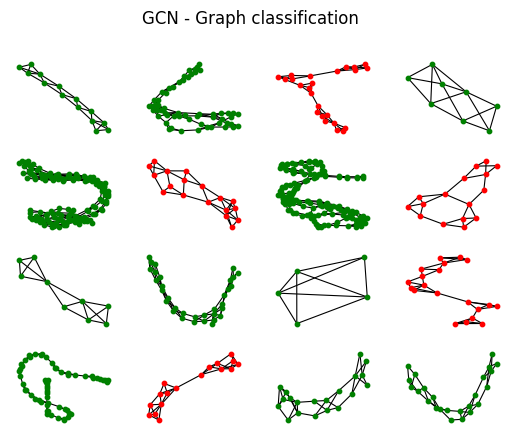

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

fig, ax = plt.subplots(4, 4)
fig.suptitle('GCN - Graph classification')

for i, data in enumerate(dataset[-16:]):
    # Calculate color (green if correct, red otherwise)
    out = gcn(data.x, data.edge_index, data.batch)
    color = "green" if out.argmax(dim=1) == data.y else "red"

    # Plot graph
    ix = np.unravel_index(i, ax.shape)
    ax[ix].axis('off')
    G = to_networkx(dataset[i], to_undirected=True)
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=False,
                    node_size=10,
                    node_color=color,
                    width=0.8,
                    ax=ax[ix]
                    )

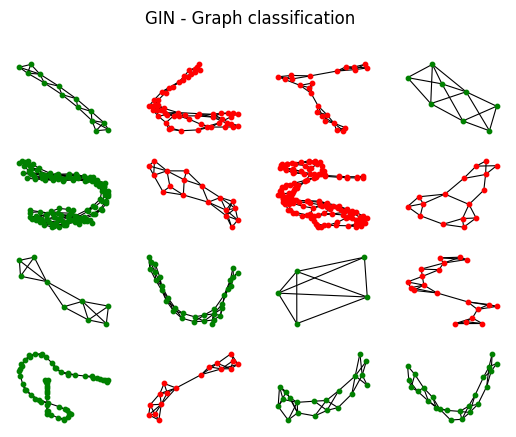

In [7]:
fig, ax = plt.subplots(4, 4)
fig.suptitle('GIN - Graph classification')

for i, data in enumerate(dataset[-16:]):
    # Calculate color (green if correct, red otherwise)
    out = gin(data.x, data.edge_index, data.batch)
    color = "green" if out.argmax(dim=1) == data.y else "red"

    # Plot graph
    ix = np.unravel_index(i, ax.shape)
    ax[ix].axis('off')
    G = to_networkx(dataset[i], to_undirected=True)
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=False,
                    node_size=10,
                    node_color=color,
                    width=0.8,
                    ax=ax[ix]
                    )

In [8]:
gcn.eval()
gin.eval()
acc_gcn = 0
acc_gin = 0
acc_ens = 0

for data in test_loader:
    # Get classifications
    out_gcn = gcn(data.x, data.edge_index, data.batch)
    out_gin = gin(data.x, data.edge_index, data.batch)
    out_ens = (out_gcn + out_gin)/2

    # Calculate accuracy scores
    acc_gcn += accuracy(out_gcn.argmax(dim=1), data.y) / len(test_loader)
    acc_gin += accuracy(out_gin.argmax(dim=1), data.y) / len(test_loader)
    acc_ens += accuracy(out_ens.argmax(dim=1), data.y) / len(test_loader)

# Print results
print(f'GCN accuracy:     {acc_gcn*100:.2f}%')
print(f'GIN accuracy:     {acc_gin*100:.2f}%')
print(f'GCN+GIN accuracy: {acc_ens*100:.2f}%')

GCN accuracy:     68.23%
GIN accuracy:     72.40%
GCN+GIN accuracy: 69.53%


full improved version

Dataset: PROTEINS(1113)
-----------------------
Number of graphs: 1113
Number of features (dataset.num_features): 3
Number of classes (dataset.num_classes): 2
Train set size: 890
Val   set size: 111
Test  set size: 112

=== Training Improved GCN ===


[Epoch 020] Train Loss: 0.5624, Train Acc: 74.27% || Val Loss: 0.5060, Val Acc: 75.68%
[Epoch 040] Train Loss: 0.5303, Train Acc: 74.16% || Val Loss: 0.4893, Val Acc: 76.58%
[Epoch 060] Train Loss: 0.5166, Train Acc: 75.73% || Val Loss: 0.4763, Val Acc: 75.68%
Early stopping triggered at epoch 71!
Improved GCN Test Loss: 0.4591, Test Acc: 77.68%

=== Training Improved GIN ===
[Epoch 020] Train Loss: 0.5637, Train Acc: 72.47% || Val Loss: 0.5712, Val Acc: 65.77%
[Epoch 040] Train Loss: 0.5466, Train Acc: 76.07% || Val Loss: 0.4887, Val Acc: 73.87%
[Epoch 060] Train Loss: 0.5089, Train Acc: 76.63% || Val Loss: 0.6059, Val Acc: 74.77%
Early stopping triggered at epoch 60!
Improved GIN Test Loss: 0.5930, Test Acc: 75.00%

GCN accuracy:     77.86%
GIN accuracy:     75.00%
GCN+GIN accuracy: 78.65%


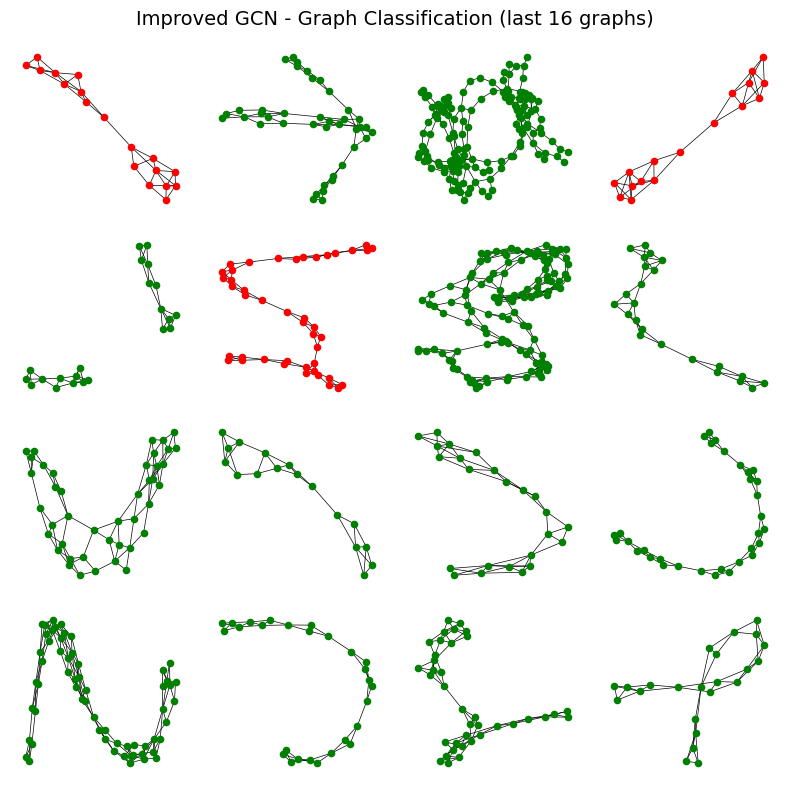

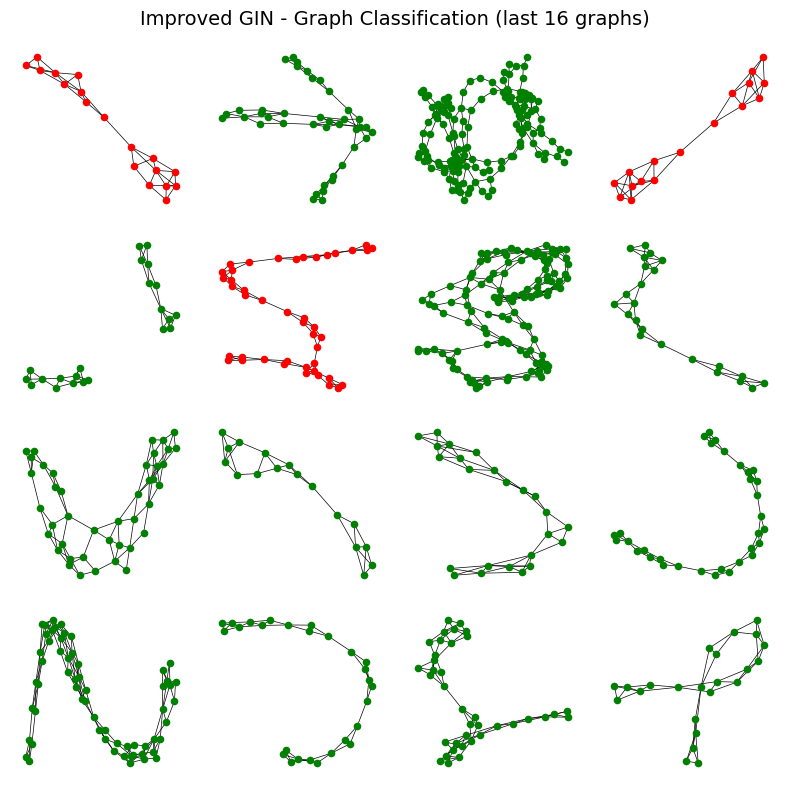

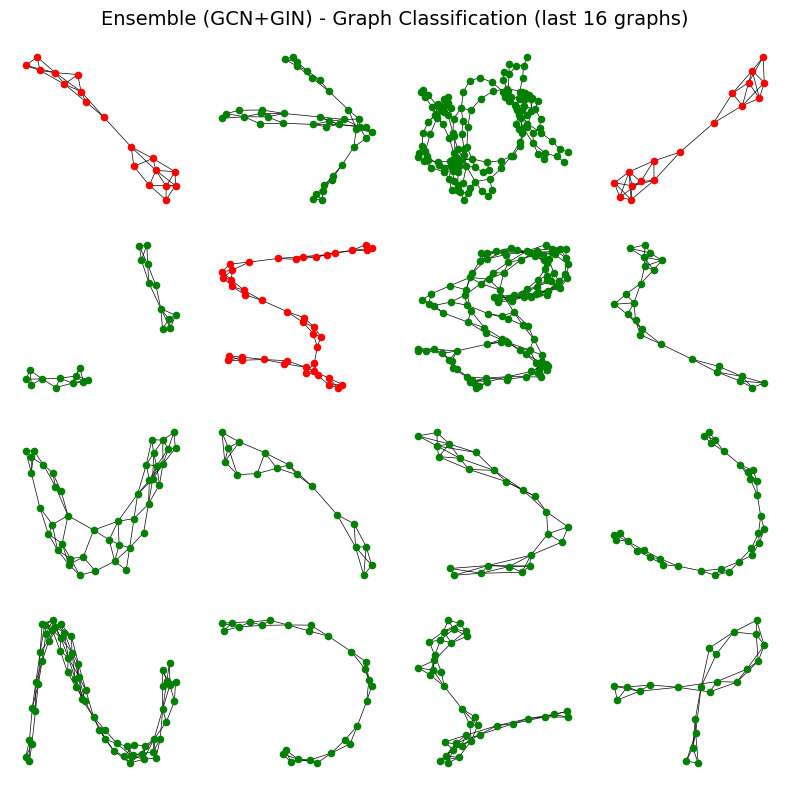

In [13]:
#############################
# 0) Installs & Imports
#############################
import os
import random
import numpy as np
import torch
import torch.nn.functional as F

# Uncomment and adjust if you need to install torch-geometric:
# !pip install -q torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric

from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import (
    GCNConv,
    GINConv,
    global_add_pool  # We'll use sum-pooling for graph-level embeddings
)
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU
from torch_geometric.utils import to_networkx

import networkx as nx
import matplotlib.pyplot as plt

#############################
# 1) Seeding for Reproducibility
#############################
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

#############################
# 2) Load PROTEINS Dataset
#############################
dataset = TUDataset(root='.', name='PROTEINS').shuffle()
print(f"Dataset: {dataset}")
print('-----------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features (dataset.num_features): {dataset.num_features}')
print(f'Number of classes (dataset.num_classes): {dataset.num_classes}')

# We can either use dataset.num_features or
# the shape of the first data sample, e.g. dataset[0].x.shape[1]
in_dim  = dataset.num_features
out_dim = dataset.num_classes

# Train/Val/Test Split
num_graphs = len(dataset)
train_dataset = dataset[: int(0.8 * num_graphs)]
val_dataset   = dataset[int(0.8 * num_graphs) : int(0.9 * num_graphs)]
test_dataset  = dataset[int(0.9 * num_graphs) : ]

print(f"Train set size: {len(train_dataset)}")
print(f"Val   set size: {len(val_dataset)}")
print(f"Test  set size: {len(test_dataset)}")

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=64, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=64, shuffle=False)

#############################
# 3) Model Definitions
#############################
class ImprovedGCN(torch.nn.Module):
    """
    A deeper GCN model using sum-pooling for graph classification.
    This matches the structure of 'Version B' but includes
    comments and naming style similar to 'Version A'.
    """
    def __init__(self, in_dim, hidden_dim, out_dim, num_layers=5, dropout=0.5):
        super().__init__()
        self.num_layers = num_layers
        self.dropout = dropout
        
        # Build multiple GCN layers
        self.convs = torch.nn.ModuleList()
        
        # First layer: from in_dim -> hidden_dim
        self.convs.append(GCNConv(in_dim, hidden_dim))
        
        # Remaining layers: hidden_dim -> hidden_dim
        for _ in range(num_layers - 1):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))
        
        # Final MLP classifier: we sum-pool to [hidden_dim], then use linear layers
        self.lin1 = Linear(hidden_dim, hidden_dim)
        self.lin2 = Linear(hidden_dim, out_dim)
    
    def forward(self, x, edge_index, batch):
        # x shape: [num_nodes, in_dim]
        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.relu(x)
        
        # Sum-pool to get graph-level embedding
        x = global_add_pool(x, batch)  # shape: [batch_size, hidden_dim]
        
        # Classification MLP
        x = self.lin1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lin2(x)
        
        return F.log_softmax(x, dim=1)


class ImprovedGIN(torch.nn.Module):
    """
    A deeper GIN model with sum-pooling and multi-layer MLP inside each GINConv.
    Also includes an MLP after pooling for classification.
    Matches 'Version B' structure but has verbose documentation like 'Version A'.
    """
    def __init__(self, in_dim, hidden_dim, out_dim, num_layers=5, dropout=0.5):
        super().__init__()
        self.num_layers = num_layers
        self.dropout = dropout
        
        # GIN layers: each GINConv is itself an MLP
        self.convs = torch.nn.ModuleList()
        
        for i in range(num_layers):
            mlp = Sequential(
                Linear(in_dim if i == 0 else hidden_dim, hidden_dim),
                BatchNorm1d(hidden_dim),
                ReLU(),
                Linear(hidden_dim, hidden_dim),
                ReLU()
            )
            self.convs.append(GINConv(mlp))
        
        # We sum-pool after each GIN layer => final dimension is hidden_dim * num_layers
        self.fc1 = Linear(hidden_dim * num_layers, hidden_dim * 2)
        self.fc2 = Linear(hidden_dim * 2, out_dim)
    
    def forward(self, x, edge_index, batch):
        # x shape: [num_nodes, in_dim]
        layer_outputs = []
        
        # Pass through each GIN layer
        for conv in self.convs:
            x = conv(x, edge_index)
            # ReLU inside MLP, so no extra activation here
            layer_outputs.append(global_add_pool(x, batch))
        
        # Concatenate all pooled layer outputs: shape => [batch_size, hidden_dim * num_layers]
        h = torch.cat(layer_outputs, dim=-1)
        
        # Classification MLP
        h = self.fc1(h)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout, training=self.training)
        h = self.fc2(h)
        
        return F.log_softmax(h, dim=1)

#############################
# 4) Utility Functions
#############################
def accuracy(pred_y, y):
    """
    Calculates accuracy given predicted labels and ground-truth labels.
    """
    return (pred_y.eq(y).sum().float() / y.size(0)).item()

@torch.no_grad()
def evaluate(model, loader, device):
    """
    Evaluates the model on the given loader, computing average loss and accuracy.
    """
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    criterion = torch.nn.CrossEntropyLoss()
    
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        total_loss += loss.item()
        
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
        total += data.y.size(0)
    
    return total_loss / len(loader), correct / total

def train_with_early_stopping(
    model, train_loader, val_loader,
    epochs=300, patience=20, lr=1e-3, weight_decay=1e-4
):
    """
    Trains the model with early stopping on the validation set.

    - epochs: maximum number of epochs
    - patience: number of epochs with no improvement before stopping
    - lr: learning rate
    - weight_decay: L2 regularization coefficient
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = torch.nn.CrossEntropyLoss()
    
    best_val_loss = float("inf")
    best_model_state = None
    epochs_no_improve = 0
    
    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0.0
        correct = 0
        total = 0
        
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data.x, data.edge_index, data.batch)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            pred = out.argmax(dim=1)
            correct += (pred == data.y).sum().item()
            total += data.y.size(0)
        
        # Compute training loss / accuracy
        train_loss = total_loss / len(train_loader)
        train_acc = correct / total
        
        # Evaluate on validation set
        val_loss, val_acc = evaluate(model, val_loader, device)
        
        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        
        if epoch % 20 == 0:
            print(f"[Epoch {epoch:03d}] "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}% || "
                  f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")
        
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch}!")
            break
    
    # Load best model state if any improvement was found
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model

#############################
# 5) Instantiate, Train, and Test
#############################
hidden_dim = 64
num_layers = 5

# ---- Train Improved GCN
print("\n=== Training Improved GCN ===")
gcn_model = ImprovedGCN(
    in_dim=in_dim,
    hidden_dim=hidden_dim,
    out_dim=out_dim,
    num_layers=num_layers,
    dropout=0.5
)
gcn_model = train_with_early_stopping(
    gcn_model, train_loader, val_loader,
    epochs=300, patience=20,
    lr=1e-3, weight_decay=1e-4
)

# Evaluate on test set
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_loss, test_acc = evaluate(gcn_model, test_loader, device)
print(f"Improved GCN Test Loss: {test_loss:.4f}, Test Acc: {test_acc*100:.2f}%\n")

# ---- Train Improved GIN
print("=== Training Improved GIN ===")
gin_model = ImprovedGIN(
    in_dim=in_dim,
    hidden_dim=hidden_dim,
    out_dim=out_dim,
    num_layers=num_layers,
    dropout=0.5
)
gin_model = train_with_early_stopping(
    gin_model, train_loader, val_loader,
    epochs=300, patience=20,
    lr=1e-3, weight_decay=1e-4
)

# Evaluate on test set
test_loss, test_acc = evaluate(gin_model, test_loader, device)
print(f"Improved GIN Test Loss: {test_loss:.4f}, Test Acc: {test_acc*100:.2f}%\n")

#############################
# 6) Optional: Model Ensemble
#############################
gcn_model.eval()
gin_model.eval()
acc_gcn, acc_gin, acc_ens = 0.0, 0.0, 0.0

for data in test_loader:
    data = data.to(device)
    out_gcn = gcn_model(data.x, data.edge_index, data.batch)
    out_gin = gin_model(data.x, data.edge_index, data.batch)
    
    # Simple averaging ensemble
    out_ens = (out_gcn + out_gin) / 2.0
    
    acc_gcn += accuracy(out_gcn.argmax(dim=1), data.y) / len(test_loader)
    acc_gin += accuracy(out_gin.argmax(dim=1), data.y) / len(test_loader)
    acc_ens += accuracy(out_ens.argmax(dim=1), data.y) / len(test_loader)

print(f"GCN accuracy:     {acc_gcn*100:.2f}%")
print(f"GIN accuracy:     {acc_gin*100:.2f}%")
print(f"GCN+GIN accuracy: {acc_ens*100:.2f}%")

#############################
# 7) Visualization (Optional)
#############################
def plot_predictions(title, model, dataset, last_n=16):
    """
    Plots the last_n graphs in the dataset, coloring nodes in green if the prediction
    is correct, and red otherwise.
    """
    model.eval()
    fig, ax = plt.subplots(4, 4, figsize=(8, 8))
    fig.suptitle(title, fontsize=14)

    for i, data in enumerate(dataset[-last_n:]):
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        pred_label = out.argmax(dim=1)
        
        # Green if correct, red if wrong
        color = "green" if pred_label == data.y else "red"
        
        G = to_networkx(data, to_undirected=True)
        ix = np.unravel_index(i, ax.shape)
        ax[ix].axis('off')
        
        nx.draw_networkx(
            G,
            pos=nx.spring_layout(G, seed=0),
            with_labels=False,
            node_size=20,
            node_color=color,
            width=0.5,
            ax=ax[ix]
        )
    plt.tight_layout()
    plt.show()

# Plot the GCN results on last 16 graphs
plot_predictions("Improved GCN - Graph Classification (last 16 graphs)", gcn_model, dataset, last_n=16)

# Plot the GIN results on last 16 graphs
plot_predictions("Improved GIN - Graph Classification (last 16 graphs)", gin_model, dataset, last_n=16)

# (Optional) Plot the Ensemble
fig, ax = plt.subplots(4, 4, figsize=(8, 8))
fig.suptitle('Ensemble (GCN+GIN) - Graph Classification (last 16 graphs)', fontsize=14)

for i, data in enumerate(dataset[-16:]):
    data = data.to(device)
    out_gcn = gcn_model(data.x, data.edge_index, data.batch)
    out_gin = gin_model(data.x, data.edge_index, data.batch)
    
    out_ens = (out_gcn + out_gin) / 2.0
    pred_label = out_ens.argmax(dim=1)
    color = "green" if pred_label == data.y else "red"
    
    G = to_networkx(data, to_undirected=True)
    ix = np.unravel_index(i, ax.shape)
    ax[ix].axis('off')
    
    nx.draw_networkx(
        G,
        pos=nx.spring_layout(G, seed=0),
        with_labels=False,
        node_size=20,
        node_color=color,
        width=0.5,
        ax=ax[ix]
    )

plt.tight_layout()
plt.show()